In [1]:
"""
Hello y'all see this?
"""
from google.colab import drive
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.preprocessing import LabelEncoder

In [2]:
# Connect Colab to Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unzip training data, run once
#!unzip drive/MyDrive/data/train.zip -d drive/MyDrive/data/

In [ ]:
# Unzip validation data, run once
#!unzip drive/MyDrive/data/validation.zip -d drive/MyDrive/data/

In [4]:
# This code chunk puts file names of all training/validation images and
# their labels in seperate dataframes

train_paths = []
train_labels = []
validation_paths = []
validation_labels = []
troot = 'drive/MyDrive/data/train-cropped'
vroot = 'drive/MyDrive/data/validation-cropped'

## Google drive will time out, run twice
for f in os.listdir(troot):
  # tpath = os.path.join(troot, f)
  tlabel = f[-10:-8]
  train_paths.append(f)
  train_labels.append(tlabel)

for f in os.listdir(vroot):
  # vpath = os.path.join(vroot, f)
  vlabel = f[-10:-8]
  validation_paths.append(f)
  validation_labels.append(vlabel)

train_images = pd.DataFrame({'path': train_paths,
                             'label': train_labels})
validation_images = pd.DataFrame({'path': validation_paths,
                                  'label': validation_labels})

In [5]:
def get_subset(n, data, seed=123):
  """
  input: number of samples, dataframe to be sampled from

  output: subset of rows from dataframe
  """
  random.seed(seed)
  sub = random.sample(range(data.shape[0] + 1), n)
  return data.iloc[sub,:]

In [6]:
imageWidth, imageHeight = 128, 128
channel = 1
imageSize = (imageWidth, imageHeight)
nCategories = 5

# Create model
model = Sequential()

model.add(Conv2D(filters = 64,
                 kernel_size=2,
                 activation='relu',
                 input_shape=(imageWidth, imageHeight, channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(16,
                 kernel_size = 2,
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#model.add(Conv2D(filters = 128,
#                 kernel_size=2,
#                 activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(nCategories, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      320       
                                                                 
 batch_normalization (Batch  (None, 127, 127, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 16)        4112      
                                                                 
 batch_normalization_1 (Bat  (None, 62, 62, 16)        6

In [7]:
# Prepare training data generator

train_subset = get_subset(1000, train_images)

train_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = train_subset,
    directory = troot,         # `train_subset` contains absolute paths
    x_col='path',
    y_col='label',
    class_mode='categorical',  # target is 2-D array of one-hot encoded labels
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )
label_map = train_generator.class_indices

Found 1000 validated image filenames belonging to 5 classes.


In [8]:
## Model Training:
history = model.fit(
    train_generator,
    epochs = 1
)

32/32 [==============================] - 303s 9s/step - loss: 0.9851 - accuracy: 0.6820


In [9]:
# Prepare validation data generator

validation_subset = get_subset(1000, validation_images)

validation_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = validation_subset,
    directory = vroot,
    x_col='path',
    class_mode= None,
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )

Found 1000 validated image filenames.


In [10]:
## Make categorical prediction:
print(" --- Predicting on validation data ---")
phat = model.predict(validation_generator)
print("Predicted probability array shape:", phat.shape)
print("Example:\n", phat[:5])

 --- Predicting on validation data ---
32/32 [==============================] - 379s 12s/step
Predicted probability array shape: (1000, 5)
Example:
 [[0.19759619 0.4654016  0.03549956 0.2682546  0.03324803]
 [0.16630612 0.4407733  0.02587593 0.33691448 0.03013018]
 [0.19244486 0.47516948 0.03421331 0.265268   0.03290444]
 [0.20885792 0.43899915 0.03273744 0.2770533  0.04235217]
 [0.16779849 0.4132076  0.02546692 0.36307985 0.03044707]]


In [11]:
## Convert labels to categories:
validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
                                           index=validation_subset.index)
print(validation_subset.head())
labelMap = {v: k for k, v in label_map.items()}
validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)
print("confusion matrix (validation)")
print(pd.crosstab(validation_subset.label, validation_subset.predicted))
print("Validation accuracy", np.mean(validation_subset.label == validation_subset.predicted))

                                  path label  predicted
428   tolstoy-voina-i-mir-3_RU-atq.jpg    RU          1
2192            novel_00047_TH-abe.jpg    TH          1
714   tolstoy-voina-i-mir-3_RU-cgy.jpg    RU          1
6299           chinese-laws_ZN-cjo.jpg    ZN          1
3336            novel_00011_TH-adl.jpg    TH          1
confusion matrix (validation)
predicted   EN
label         
DA         147
EN         259
RU         214
TH         230
ZN         150
Validation accuracy 0.259


<ipython-input-11-8fb2affa4847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
<ipython-input-11-8fb2affa4847>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)


Example wrong results (validation data)
                                     path label predicted
2174               novel_00044_TH-ach.jpg    TH        EN
2891               novel_00087_TH-aib.jpg    TH        EN
5233    derzhavin-duhovnye-ody_RU-atv.jpg    RU        EN
7297  aakjaer-samlede-verker-1_DA-bzk.jpg    DA        EN
3927               novel_00033_TH-aes.jpg    TH        EN
2742               novel_00081_TH-aap.jpg    TH        EN
2882               novel_00086_TH-aao.jpg    TH        EN
488      tolstoy-voina-i-mir-3_RU-arw.jpg    RU        EN
6439              chinese-laws_ZN-dbm.jpg    ZN        EN
6807              chinese-laws_ZN-fwu.jpg    ZN        EN


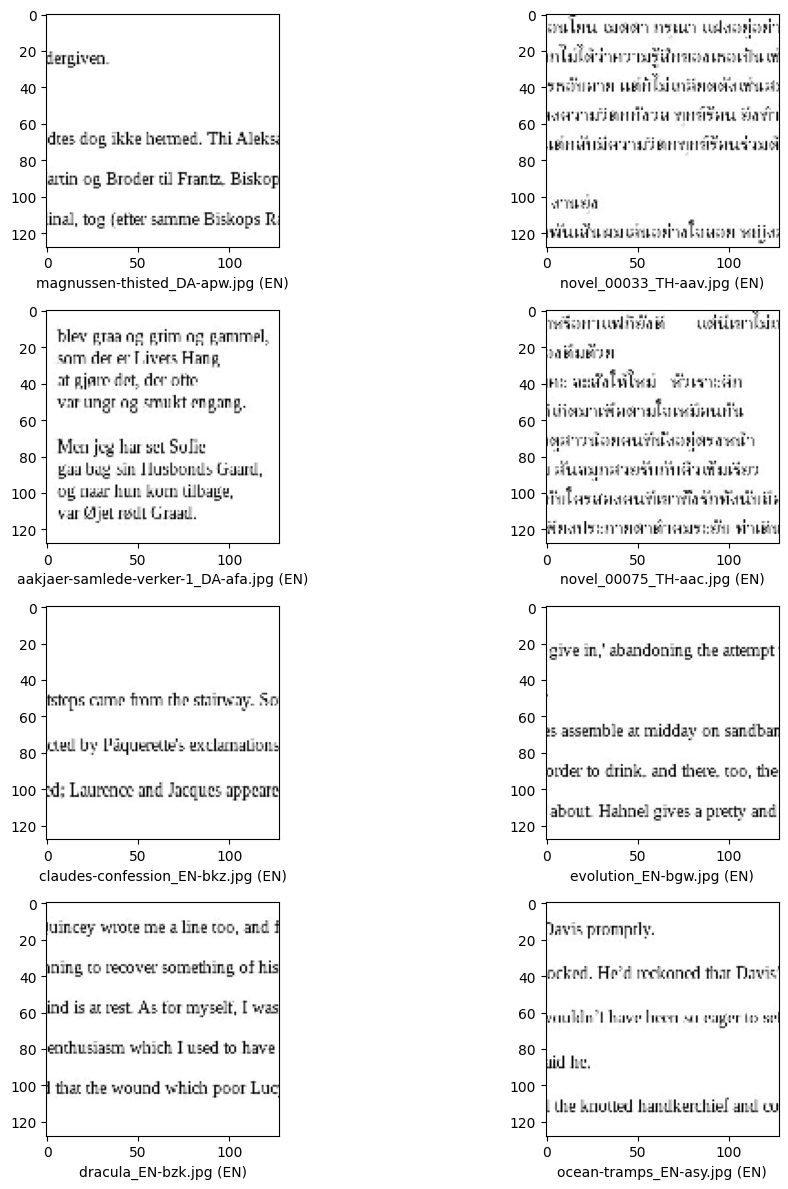

In [12]:
## Print and plot misclassified results
wrongResults = validation_subset[validation_subset.predicted != validation_subset.label]
rows = np.random.choice(wrongResults.index, min(4, wrongResults.shape[0]), replace=False)
print("Example wrong results (validation data)")
print(wrongResults.sample(min(10, wrongResults.shape[0])))

## Plot 4 wrong and 4 correct results
plt.figure(figsize=(12, 12))
index = 1
for row in rows:
    filename = wrongResults.loc[row, 'path']
    predicted = wrongResults.loc[row, 'predicted']
    img = load_img(os.path.join(vroot, filename), target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
# now show correct results
index = 5
correctResults = validation_subset[validation_subset.predicted == validation_subset.label]
rows = np.random.choice(correctResults.index,
                        min(4, correctResults.shape[0]), replace=False)
for row in rows:
    filename = correctResults.loc[row, 'path']
    predicted = correctResults.loc[row, 'predicted']
    img = load_img(os.path.join(vroot,filename), target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
plt.tight_layout()
plt.show()